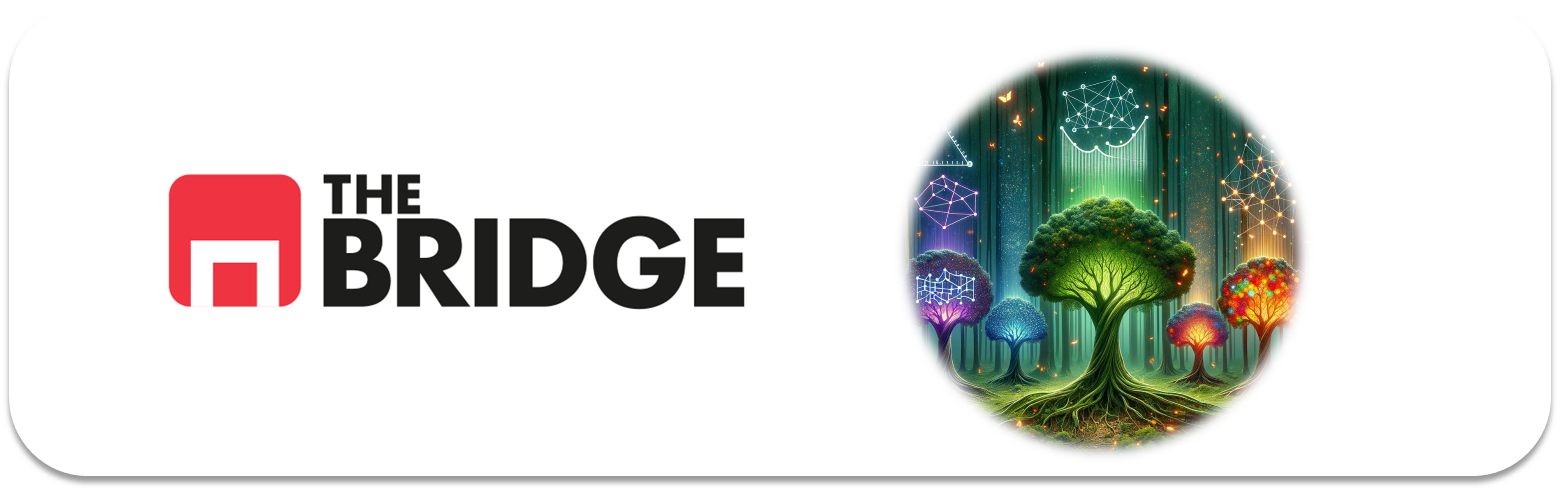

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de Hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [83]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

### Pasos que voy a seguir:
1. Carga y exploración inicial del dataset
2. Limpieza de datos
3. Análisis exploratorio (EDA)
4. Preparación de datos (encoding, scaling si necesario)
5. Split train/test
6. Modelo baseline: Regresión Logística (sin optimizar)
7. Árbol de Decisión básico
8. Optimización de hiperparámetros del árbol
9. Comparación de modelos
10. Evaluación final y conclusiones

In [2]:
df = pd.read_csv("data/bank-full.csv", sep=';')

In [3]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
df.columns.tolist()

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [8]:
print(df['y'].value_counts())
print("\nPorcentajes:")
print(df['y'].value_counts(normalize=True) * 100)

y
no     39922
yes     5289
Name: count, dtype: int64

Porcentajes:
y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


### 1 Limpieza

Al no haber nulos la limpieza sera minima

In [9]:
print("VALORES ÚNICOS EN VARIABLES CATEGÓRICAS")


categoricas = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
               'contact', 'month', 'poutcome', 'y']

for col in categoricas:
    print(f"\n{col.upper()}:")
    print(f"  Valores únicos: {df[col].nunique()}")
    print(f"  Valores: {df[col].unique()}")

VALORES ÚNICOS EN VARIABLES CATEGÓRICAS

JOB:
  Valores únicos: 12
  Valores: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

MARITAL:
  Valores únicos: 3
  Valores: ['married' 'single' 'divorced']

EDUCATION:
  Valores únicos: 4
  Valores: ['tertiary' 'secondary' 'unknown' 'primary']

DEFAULT:
  Valores únicos: 2
  Valores: ['no' 'yes']

HOUSING:
  Valores únicos: 2
  Valores: ['yes' 'no']

LOAN:
  Valores únicos: 2
  Valores: ['no' 'yes']

CONTACT:
  Valores únicos: 3
  Valores: ['unknown' 'cellular' 'telephone']

MONTH:
  Valores únicos: 12
  Valores: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

POUTCOME:
  Valores únicos: 4
  Valores: ['unknown' 'failure' 'other' 'success']

Y:
  Valores únicos: 2
  Valores: ['no' 'yes']


In [10]:
print("CONTEO DE 'unknown' EN VARIABLES CATEGÓRICAS")


for col in categoricas:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        porcentaje = (unknown_count / len(df)) * 100
        print(f"{col}: {unknown_count} ({porcentaje:.2f}%)")

CONTEO DE 'unknown' EN VARIABLES CATEGÓRICAS
job: 288 (0.64%)
education: 1857 (4.11%)
contact: 13020 (28.80%)
poutcome: 36959 (81.75%)


In [11]:
print("ANÁLISIS DE 'duration' (DURACIÓN DE LA LLAMADA)")

print(df['duration'].describe())

# Correlación entre duration y el target

print(df.groupby('y')['duration'].mean())

ANÁLISIS DE 'duration' (DURACIÓN DE LA LLAMADA)
count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64
y
no     221.182806
yes    537.294574
Name: duration, dtype: float64


In [12]:
features_usar = [
    # Datos del cliente
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
    # Datos del contacto
    'contact', 'day', 'month',
    # Datos de campañas anteriores
    'campaign', 'pdays', 'previous', 'poutcome'
]

# Target
target = 'y'

In [13]:
df_clean = df.copy()

In [14]:
df_clean.shape

(45211, 17)

In [15]:
print("ELIMINANDO 'duration'")

df_clean = df_clean.drop('duration', axis=1)
df_clean.shape

ELIMINANDO 'duration'


(45211, 16)

Eliminamos duracion porque solo conocemos la duracion de las llamadas despues de estas, por lo que en produccion no tendriamos este dato.

In [16]:
nulos = df_clean.isnull().sum().sum()
nulos

np.int64(0)

### 2. SPLIT

In [17]:
X = df_clean.drop('y', axis=1)
y = df_clean['y']

In [18]:
# 2. Verificar distribución del target ANTES del split

distribucion_original = y.value_counts(normalize=True) * 100
print(distribucion_original)


y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% para test
    random_state=42,      # Semilla para reproducibilidad
    stratify=y            # ¡IMPORTANTE! Mantiene proporción 88%-12%
)

In [20]:
# 4. Tamaños resultantes

print(f"   X_train: {X_train.shape} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   y_train: {y_train.shape}")


print(f"   X_test: {X_test.shape} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   y_test: {y_test.shape}")

   X_train: (36168, 15) (80.0%)
   y_train: (36168,)
   X_test: (9043, 15) (20.0%)
   y_test: (9043,)


In [21]:
# 5. Verificar estratificación (distribuciones deben ser similares)

print("VERIFICACIÓN DE LA ESTRATIFICACIÓN")



print(y_train.value_counts())
print("Porcentajes:")
distribucion_train = y_train.value_counts(normalize=True) * 100
print(distribucion_train)


print(y_test.value_counts())
print("Porcentajes:")
distribucion_test = y_test.value_counts(normalize=True) * 100
print(distribucion_test)


comparacion = pd.DataFrame({
    'Original': distribucion_original.values,
    'Train': distribucion_train.values,
    'Test': distribucion_test.values
}, index=['no', 'yes'])
print(comparacion)

VERIFICACIÓN DE LA ESTRATIFICACIÓN
y
no     31937
yes     4231
Name: count, dtype: int64
Porcentajes:
y
no     88.301814
yes    11.698186
Name: proportion, dtype: float64
y
no     7985
yes    1058
Name: count, dtype: int64
Porcentajes:
y
no     88.300343
yes    11.699657
Name: proportion, dtype: float64
     Original      Train       Test
no   88.30152  88.301814  88.300343
yes  11.69848  11.698186  11.699657


### 3.  MINI EDA

In [22]:
# 1. Visión general de TRAIN

print("VISIÓN GENERAL DE TRAIN")

print(f"\nDimensiones: {X_train.shape}")
print(f"Features: {X_train.shape[1]}")
print(f"Registros: {X_train.shape[0]}")


VISIÓN GENERAL DE TRAIN

Dimensiones: (36168, 15)
Features: 15
Registros: 36168


In [23]:
# 2. Tipos de variables

print("TIPOS DE VARIABLES")


numericas = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoricas = X_train.select_dtypes(include=['object']).columns.tolist()

print(f" Variables NUMÉRICAS ({len(numericas)}):")
print(numericas)

print(f" Variables CATEGÓRICAS ({len(categoricas)}):")
print(categoricas)

TIPOS DE VARIABLES
 Variables NUMÉRICAS (6):
['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
 Variables CATEGÓRICAS (9):
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [24]:
# 3. Estadísticas de variables numéricas

print("ESTADÍSTICAS DE VARIABLES NUMÉRICAS (TRAIN)")

print(X_train[numericas].describe())

ESTADÍSTICAS DE VARIABLES NUMÉRICAS (TRAIN)
                age       balance           day      campaign         pdays  \
count  36168.000000   36168.00000  36168.000000  36168.000000  36168.000000   
mean      40.892999    1365.49342     15.817961      2.763935     40.157238   
std       10.627075    3068.54350      8.331980      3.104161    100.162614   
min       18.000000   -8019.00000      1.000000      1.000000     -1.000000   
25%       33.000000      74.00000      8.000000      1.000000     -1.000000   
50%       39.000000     451.00000     16.000000      2.000000     -1.000000   
75%       48.000000    1430.25000     21.000000      3.000000     -1.000000   
max       95.000000  102127.00000     31.000000     63.000000    871.000000   

           previous  
count  36168.000000  
mean       0.581730  
std        2.408766  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


In [25]:
# Crear DataFrame temporal combinando X_train e y_train
df_train = X_train.copy()
df_train['y'] = y_train

# Analizar cada variable numérica
numericas = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

ANÁLISIS: VARIABLES NUMÉRICAS VS TARGET
 AGE
          mean  median        std
y                                
no   40.797445    39.0  10.175616
yes  41.614276    38.0  13.537990

Diferencia de medias (yes - no): 0.82
→ Los que dijeron 'yes' tienen age MÁS ALTO
 BALANCE
            mean  median          std
y                                    
no   1304.038106   419.0  2976.744006
yes  1829.378634   740.0  3655.717378

Diferencia de medias (yes - no): 525.34
→ Los que dijeron 'yes' tienen balance MÁS ALTO
 DAY
          mean  median       std
y                               
no   15.898613    16.0  8.303445
yes  15.209170    15.0  8.520700

Diferencia de medias (yes - no): -0.69
→ Los que dijeron 'no' tienen day MÁS ALTO
 CAMPAIGN
         mean  median       std
y                              
no   2.845258     2.0  3.216653
yes  2.150083     2.0  1.960346

Diferencia de medias (yes - no): -0.70
→ Los que dijeron 'no' tienen campaign MÁS ALTO
 PDAYS


          mean  median         std
y                                 
no   36.485957    -1.0   96.835781
yes  67.869298    -1.0  118.798423

Diferencia de medias (yes - no): 31.38
→ Los que dijeron 'yes' tienen pdays MÁS ALTO
 PREVIOUS
         mean  median       std
y                              
no   0.503836     0.0  2.370703
yes  1.169700     0.0  2.604876

Diferencia de medias (yes - no): 0.67
→ Los que dijeron 'yes' tienen previous MÁS ALTO


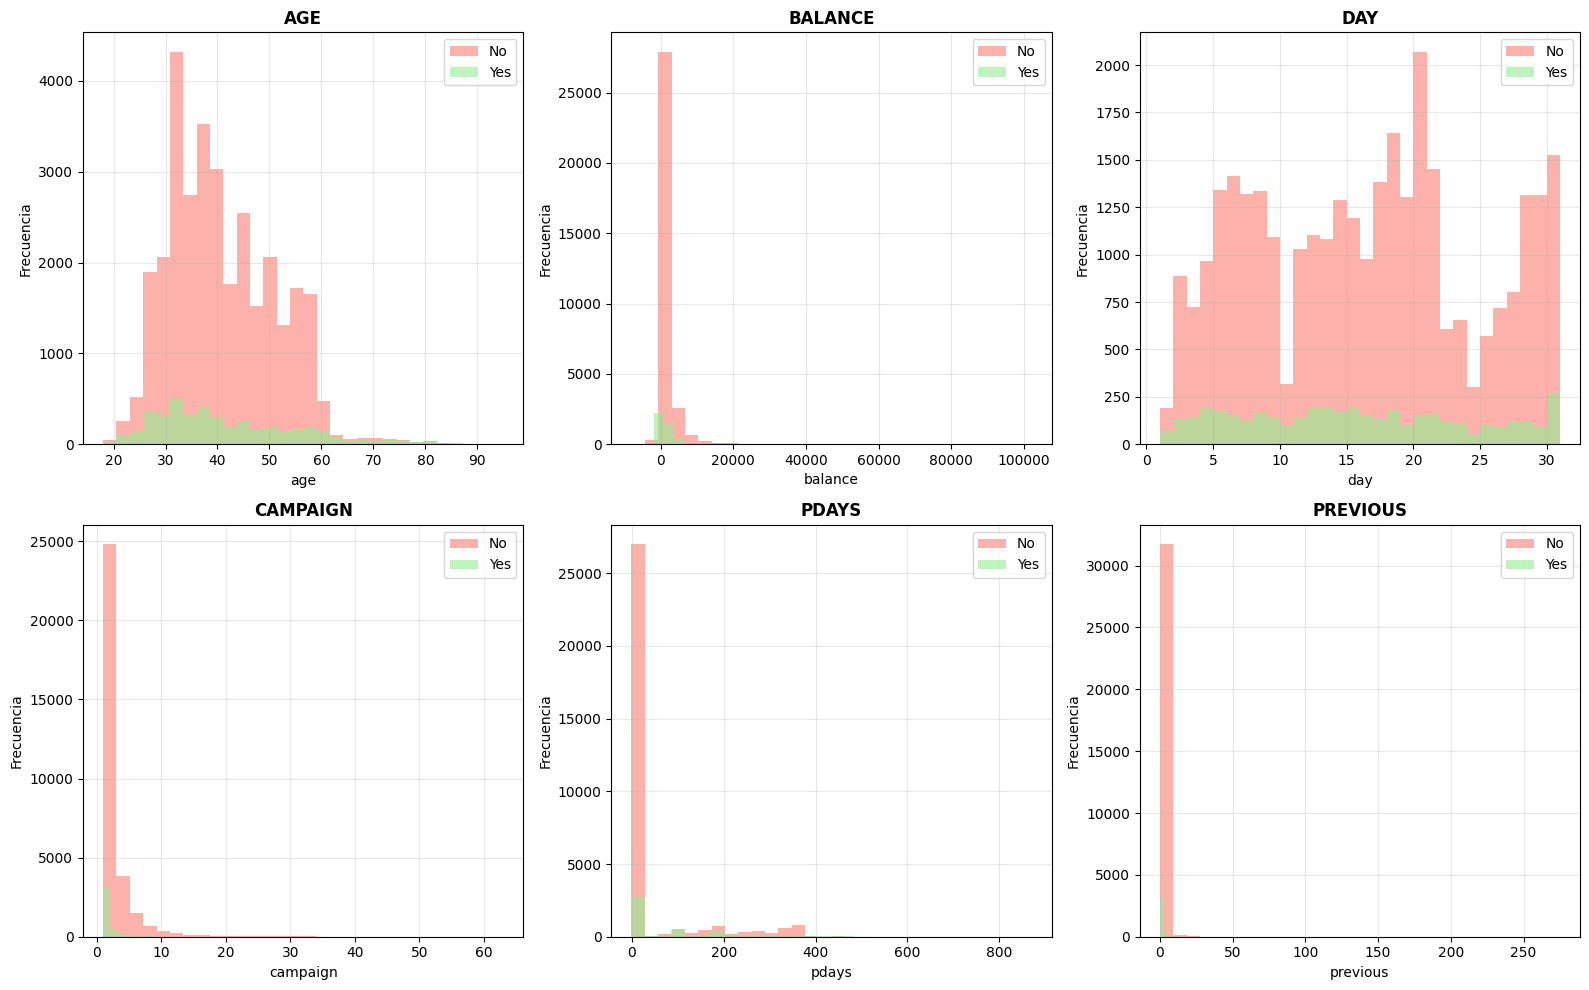

In [26]:
print("ANÁLISIS: VARIABLES NUMÉRICAS VS TARGET")
for var in numericas:

   
    print(f" {var.upper()}")

    
    # Estadísticas por grupo
    stats = df_train.groupby('y')[var].agg(['mean', 'median', 'std'])
    print(stats)
    
    # Diferencia entre grupos
    diff_mean = stats.loc['yes', 'mean'] - stats.loc['no', 'mean']
    print(f"\nDiferencia de medias (yes - no): {diff_mean:.2f}")
    
    if diff_mean > 0:
        print(f"→ Los que dijeron 'yes' tienen {var} MÁS ALTO")
    else:
        print(f"→ Los que dijeron 'no' tienen {var} MÁS ALTO")

# Visualización de las distribuciones
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(numericas):
    # Histogramas separados por target
    df_train[df_train['y'] == 'no'][var].hist(bins=30, alpha=0.6, 
                                                label='No', color='salmon', 
                                                ax=axes[i])
    df_train[df_train['y'] == 'yes'][var].hist(bins=30, alpha=0.6, 
                                                 label='Yes', color='lightgreen', 
                                                 ax=axes[i])
    axes[i].set_title(f'{var.upper()}', fontweight='bold', fontsize=12)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
print("ANÁLISIS: VARIABLES CATEGÓRICAS VS TARGET")


categoricas = ['job', 'marital', 'education', 'default', 'housing', 
               'loan', 'contact', 'month', 'poutcome']

for var in categoricas:
    print(f"\n{'─'*70}")
    print(f" {var.upper()}")
    print('─'*70)
    
    # Tabla cruzada: cantidad por categoría y target
    cross_tab = pd.crosstab(df_train[var], df_train['y'], margins=True)
    print(cross_tab)
    
    # Porcentaje de "yes" por categoría
    print(f"\n% de 'yes' por categoría de {var}:")
    pct_yes = df_train.groupby(var)['y'].apply(lambda x: (x == 'yes').sum() / len(x) * 100)
    pct_yes_sorted = pct_yes.sort_values(ascending=False)
    print(pct_yes_sorted)
    
    # Identificar la categoría con mayor conversión
    mejor_categoria = pct_yes_sorted.index[0]
    mejor_pct = pct_yes_sorted.iloc[0]
    print(f"\n Mejor categoría: '{mejor_categoria}' con {mejor_pct:.2f}% de 'yes'")

print("\n" + "="*70)

ANÁLISIS: VARIABLES CATEGÓRICAS VS TARGET

──────────────────────────────────────────────────────────────────────
 JOB
──────────────────────────────────────────────────────────────────────
y                 no   yes    All
job                              
admin.          3632   509   4141
blue-collar     7259   571   7830
entrepreneur    1085   101   1186
housemaid        928    85   1013
management      6470  1041   7511
retired         1396   416   1812
self-employed   1101   142   1243
services        3050   298   3348
student          539   219    758
technician      5405   663   6068
unemployed       866   158   1024
unknown          206    28    234
All            31937  4231  36168

% de 'yes' por categoría de job:
job
student          28.891821
retired          22.958057
unemployed       15.429688
management       13.859672
admin.           12.291717
unknown          11.965812
self-employed    11.423974
technician       10.926170
services          8.900836
entrepreneur      8

VISUALIZACIÓN: CATEGÓRICAS MÁS IMPORTANTES


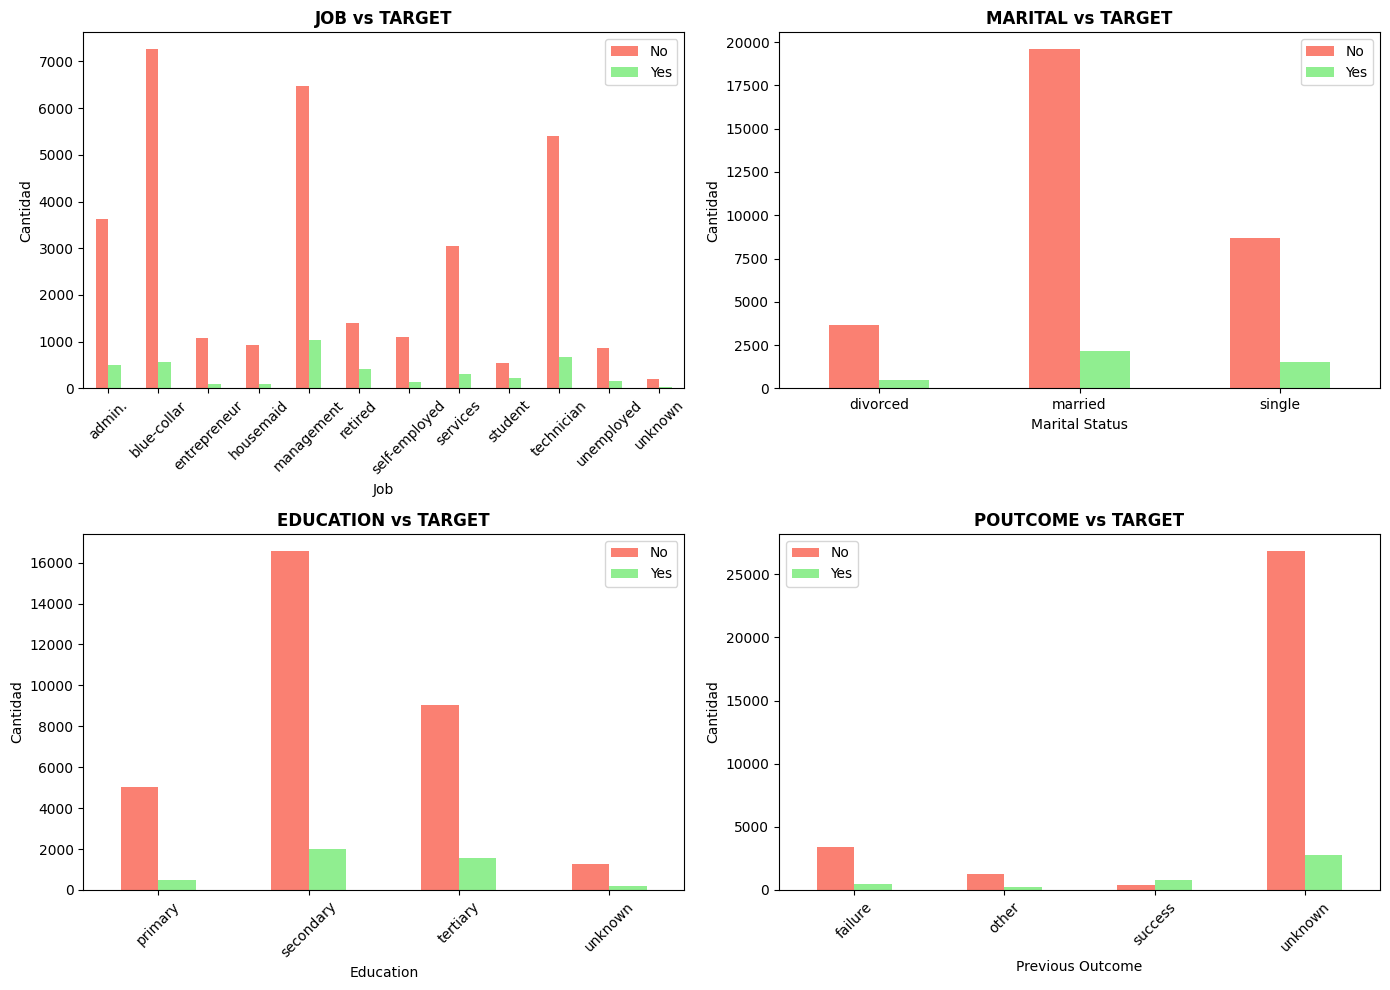

In [28]:
print("VISUALIZACIÓN: CATEGÓRICAS MÁS IMPORTANTES")


# Vamos a visualizar las 4 categóricas más relevantes
# (job, marital, education, poutcome)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. JOB
df_job = df_train.groupby(['job', 'y']).size().unstack(fill_value=0)
df_job.plot(kind='bar', ax=axes[0, 0], color=['salmon', 'lightgreen'])
axes[0, 0].set_title('JOB vs TARGET', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Job')
axes[0, 0].set_ylabel('Cantidad')
axes[0, 0].legend(['No', 'Yes'])
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. MARITAL
df_marital = df_train.groupby(['marital', 'y']).size().unstack(fill_value=0)
df_marital.plot(kind='bar', ax=axes[0, 1], color=['salmon', 'lightgreen'])
axes[0, 1].set_title('MARITAL vs TARGET', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Marital Status')
axes[0, 1].set_ylabel('Cantidad')
axes[0, 1].legend(['No', 'Yes'])
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. EDUCATION
df_education = df_train.groupby(['education', 'y']).size().unstack(fill_value=0)
df_education.plot(kind='bar', ax=axes[1, 0], color=['salmon', 'lightgreen'])
axes[1, 0].set_title('EDUCATION vs TARGET', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Education')
axes[1, 0].set_ylabel('Cantidad')
axes[1, 0].legend(['No', 'Yes'])
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. POUTCOME
df_poutcome = df_train.groupby(['poutcome', 'y']).size().unstack(fill_value=0)
df_poutcome.plot(kind='bar', ax=axes[1, 1], color=['salmon', 'lightgreen'])
axes[1, 1].set_title('POUTCOME vs TARGET', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Previous Outcome')
axes[1, 1].set_ylabel('Cantidad')
axes[1, 1].legend(['No', 'Yes'])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

MATRIZ DE CORRELACIÓN (Variables Numéricas)
               age   balance       day  campaign     pdays  previous
age       1.000000  0.096164 -0.009765  0.007818 -0.024410  0.001832
balance   0.096164  1.000000  0.002354 -0.014405  0.003141  0.017328
day      -0.009765  0.002354  1.000000  0.161620 -0.093492 -0.049443
campaign  0.007818 -0.014405  0.161620  1.000000 -0.088898 -0.031240
pdays    -0.024410  0.003141 -0.093492 -0.088898  1.000000  0.438963
previous  0.001832  0.017328 -0.049443 -0.031240  0.438963  1.000000


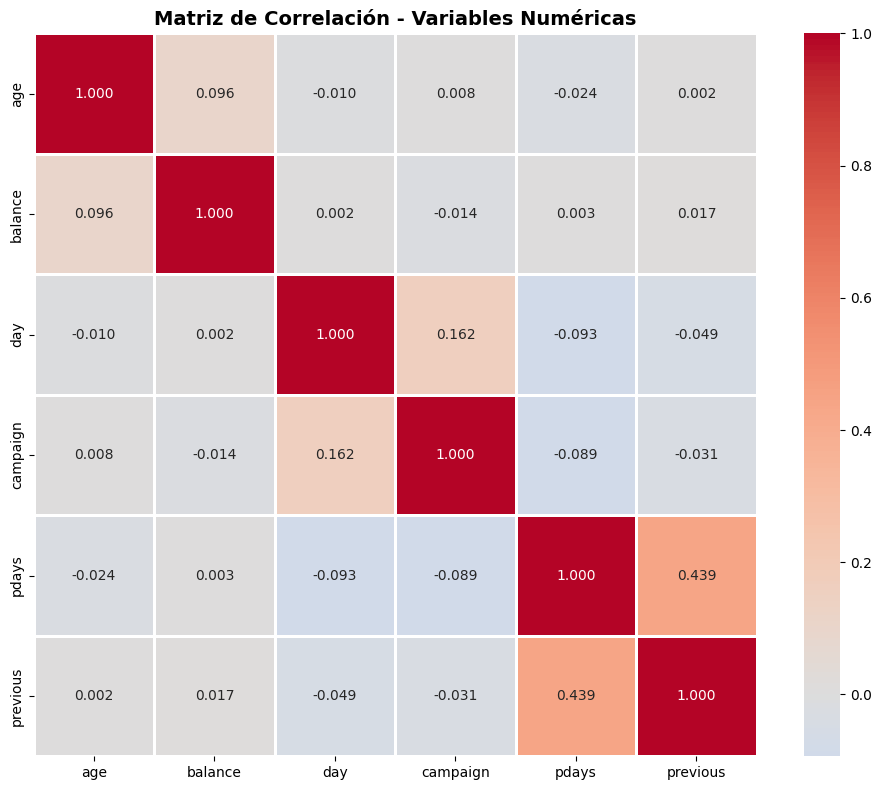


 Busca correlaciones altas (>0.7 o <-0.7)
   Variables muy correlacionadas pueden ser redundantes


In [29]:
print("MATRIZ DE CORRELACIÓN (Variables Numéricas)")

# Calcular correlación
correlation = df_train[numericas].corr()
print(correlation)

# Visualizar con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlación - Variables Numéricas', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n Busca correlaciones altas (>0.7 o <-0.7)")
print("   Variables muy correlacionadas pueden ser redundantes")

### 4 - SELECCION DE FEATURES.

In [30]:
# Features a MANTENER
features_mantener = [
    # Demográficas del cliente
    'age', 'job', 'marital', 'education', 'balance',
    
    # Productos financieros
    'default', 'housing', 'loan',
    
    # Información del contacto actual
    'contact', 'day', 'month',
    
    # Información de campañas anteriores
    'campaign', 'pdays', 'previous', 'poutcome'
]

print(f"\n FEATURES SELECCIONADAS: {len(features_mantener)}")
print("-"*70)
for i, feat in enumerate(features_mantener, 1):
    print(f"{i:2d}. {feat}")


 FEATURES SELECCIONADAS: 15
----------------------------------------------------------------------
 1. age
 2. job
 3. marital
 4. education
 5. balance
 6. default
 7. housing
 8. loan
 9. contact
10. day
11. month
12. campaign
13. pdays
14. previous
15. poutcome


In [31]:
# Verificar que todas existen en X_train
features_disponibles = X_train.columns.tolist()
features_faltantes = [f for f in features_mantener if f not in features_disponibles]

if features_faltantes:
    print(f"\n FEATURES FALTANTES: {features_faltantes}")
else:
    print(f"\n Todas las features están disponibles")


 Todas las features están disponibles


In [32]:
# Crear los datasets finales con las features seleccionadas
X_train_selected = X_train[features_mantener].copy()
X_test_selected = X_test[features_mantener].copy()

print(f"\n DATASETS CON FEATURES SELECCIONADAS:")
print(f"   X_train_selected: {X_train_selected.shape}")
print(f"   X_test_selected: {X_test_selected.shape}")


 DATASETS CON FEATURES SELECCIONADAS:
   X_train_selected: (36168, 15)
   X_test_selected: (9043, 15)


### 5. TRATAMIENTO DE VARIABLES.

In [33]:

print("PARTE 1: CODIFICACIÓN DE VARIABLES BINARIAS")


# Variables binarias (solo 2 valores: yes/no)
variables_binarias = ['default', 'housing', 'loan']

# Copiar los datasets para no modificar los originales
X_train_encoded = X_train_selected.copy()
X_test_encoded = X_test_selected.copy()

print("\nCodificando variables binarias (yes=1, no=0):")


for var in variables_binarias:
    # Verificar valores únicos ANTES
    print(f"\n{var.upper()}:")
    print(f"  Valores antes: {X_train_encoded[var].unique()}")
    
    # Codificar: yes=1, no=0
    # Importante: usar map() para mantener consistencia
    X_train_encoded[var] = X_train_encoded[var].map({'yes': 1, 'no': 0})
    X_test_encoded[var] = X_test_encoded[var].map({'yes': 1, 'no': 0})
    
    # Verificar valores únicos DESPUÉS
    print(f"  Valores después: {X_train_encoded[var].unique()}")
    

# Codificar también el TARGET (y_train, y_test)

print("\nCodificando TARGET 'y' (yes=1, no=0):")

print(f"Valores antes: {y_train.unique()}")

y_train_encoded = y_train.map({'yes': 1, 'no': 0})
y_test_encoded = y_test.map({'yes': 1, 'no': 0})

print(f"Valores después: {y_train_encoded.unique()}")
print(f" Target codificado correctamente")

print(f"\nDistribución del target codificado:")
print(y_train_encoded.value_counts())

PARTE 1: CODIFICACIÓN DE VARIABLES BINARIAS

Codificando variables binarias (yes=1, no=0):

DEFAULT:
  Valores antes: ['no' 'yes']
  Valores después: [0 1]

HOUSING:
  Valores antes: ['no' 'yes']
  Valores después: [0 1]

LOAN:
  Valores antes: ['no' 'yes']
  Valores después: [0 1]

Codificando TARGET 'y' (yes=1, no=0):
Valores antes: ['no' 'yes']
Valores después: [0 1]
 Target codificado correctamente

Distribución del target codificado:
y
0    31937
1     4231
Name: count, dtype: int64


In [34]:
print("PARTE 2: ONE-HOT ENCODING DE VARIABLES CATEGÓRICAS")


# Variables categóricas (más de 2 valores)
variables_categoricas = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

print(f"\nVariables a codificar: {variables_categoricas}")
print(f"Dimensiones ANTES del One-Hot Encoding:")
print(f"  X_train: {X_train_encoded.shape}")
print(f"  X_test: {X_test_encoded.shape}")

# Aplicar One-Hot Encoding
# drop_first=True para evitar multicolinealidad (dummy variable trap)
X_train_encoded = pd.get_dummies(
    X_train_encoded, 
    columns=variables_categoricas,
    drop_first=True,  # Elimina la primera categoría de cada variable
    dtype=int         # Asegura que sean enteros (0 o 1)
)

X_test_encoded = pd.get_dummies(
    X_test_encoded,
    columns=variables_categoricas,
    drop_first=True,
    dtype=int
)

print(f"\nDimensiones DESPUÉS del One-Hot Encoding:")
print(f"  X_train: {X_train_encoded.shape}")
print(f"  X_test: {X_test_encoded.shape}")

print(f"\n Se crearon {X_train_encoded.shape[1] - 15} nuevas columnas")

# Verificar que train y test tengan las MISMAS columnas
columnas_train = set(X_train_encoded.columns)
columnas_test = set(X_test_encoded.columns)

if columnas_train == columnas_test:
    print(f" Train y Test tienen las mismas columnas ({len(columnas_train)} columnas)")
else:
    print(f" WARNING: Train y Test tienen columnas diferentes")
    print(f"  Solo en train: {columnas_train - columnas_test}")
    print(f"  Solo en test: {columnas_test - columnas_train}")

PARTE 2: ONE-HOT ENCODING DE VARIABLES CATEGÓRICAS

Variables a codificar: ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
Dimensiones ANTES del One-Hot Encoding:
  X_train: (36168, 15)
  X_test: (9043, 15)

Dimensiones DESPUÉS del One-Hot Encoding:
  X_train: (36168, 41)
  X_test: (9043, 41)

 Se crearon 26 nuevas columnas
 Train y Test tienen las mismas columnas (41 columnas)


In [35]:
print("NUEVAS COLUMNAS CREADAS POR ONE-HOT ENCODING")


# Separar columnas por tipo
columnas_originales = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous',
                       'default', 'housing', 'loan']
columnas_nuevas = [col for col in X_train_encoded.columns if col not in columnas_originales]

print(f"\n Columnas originales (numéricas + binarias): {len(columnas_originales)}")
for col in columnas_originales:
    print(f"  • {col}")

print(f"\n Columnas nuevas (one-hot encoded): {len(columnas_nuevas)}")

# Agrupar por variable original
for var in variables_categoricas:
    cols_var = [col for col in columnas_nuevas if col.startswith(var + '_')]
    print(f"\n  {var.upper()} → {len(cols_var)} columnas:")
    for col in cols_var:
        print(f"    • {col}")

NUEVAS COLUMNAS CREADAS POR ONE-HOT ENCODING

 Columnas originales (numéricas + binarias): 9
  • age
  • balance
  • day
  • campaign
  • pdays
  • previous
  • default
  • housing
  • loan

 Columnas nuevas (one-hot encoded): 32

  JOB → 11 columnas:
    • job_blue-collar
    • job_entrepreneur
    • job_housemaid
    • job_management
    • job_retired
    • job_self-employed
    • job_services
    • job_student
    • job_technician
    • job_unemployed
    • job_unknown

  MARITAL → 2 columnas:
    • marital_married
    • marital_single

  EDUCATION → 3 columnas:
    • education_secondary
    • education_tertiary
    • education_unknown

  CONTACT → 2 columnas:
    • contact_telephone
    • contact_unknown

  MONTH → 11 columnas:
    • month_aug
    • month_dec
    • month_feb
    • month_jan
    • month_jul
    • month_jun
    • month_mar
    • month_may
    • month_nov
    • month_oct
    • month_sep

  POUTCOME → 3 columnas:
    • poutcome_other
    • poutcome_success
    • poutco

In [36]:
print("PARTE 3: ESCALADO DE VARIABLES NUMÉRICAS")


print("\n IMPORTANTE:")
print("  • Árboles de Decisión NO requieren escalado (son invariantes a escala)")
print("  • Regresión Logística SÍ requiere escalado")
print("\nCrearemos 2 versiones:")
print("  1. SIN escalar → para Árbol de Decisión")
print("  2. CON escalar → para Regresión Logística")

# Identificar columnas numéricas
columnas_numericas = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

# Versión SIN escalar (para árboles)
X_train_tree = X_train_encoded.copy()
X_test_tree = X_test_encoded.copy()

print(f"\n Datasets para ÁRBOL (sin escalar):")
print(f"  X_train_tree: {X_train_tree.shape}")
print(f"  X_test_tree: {X_test_tree.shape}")

# Versión CON escalar (para regresión logística)
X_train_lr = X_train_encoded.copy()
X_test_lr = X_test_encoded.copy()

# Crear y ajustar scaler SOLO con train
scaler = StandardScaler()
scaler.fit(X_train_lr[columnas_numericas])

# Aplicar a train y test
X_train_lr[columnas_numericas] = scaler.transform(X_train_lr[columnas_numericas])
X_test_lr[columnas_numericas] = scaler.transform(X_test_lr[columnas_numericas])

print(f"\n Datasets para REGRESIÓN LOGÍSTICA (escalados):")
print(f"  X_train_lr: {X_train_lr.shape}")
print(f"  X_test_lr: {X_test_lr.shape}")

print(f"\n Escalado aplicado a las {len(columnas_numericas)} variables numéricas")

PARTE 3: ESCALADO DE VARIABLES NUMÉRICAS

 IMPORTANTE:
  • Árboles de Decisión NO requieren escalado (son invariantes a escala)
  • Regresión Logística SÍ requiere escalado

Crearemos 2 versiones:
  1. SIN escalar → para Árbol de Decisión
  2. CON escalar → para Regresión Logística

 Datasets para ÁRBOL (sin escalar):
  X_train_tree: (36168, 41)
  X_test_tree: (9043, 41)

 Datasets para REGRESIÓN LOGÍSTICA (escalados):
  X_train_lr: (36168, 41)
  X_test_lr: (9043, 41)

 Escalado aplicado a las 6 variables numéricas


### 6 ENTRENAMIENTOS

In [37]:
print("MODELO 1: REGRESIÓN LOGÍSTICA (BASELINE)")


# Crear el modelo con hiperparámetros por DEFECTO
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # Maneja el desbalanceo 88%-12%
    max_iter=1000             # Suficiente para converger
)

print("\n Hiperparámetros (por defecto):")
print(f"  • class_weight: balanced")
print(f"  • max_iter: 1000")
print(f"  • solver: lbfgs (por defecto)")

MODELO 1: REGRESIÓN LOGÍSTICA (BASELINE)

 Hiperparámetros (por defecto):
  • class_weight: balanced
  • max_iter: 1000
  • solver: lbfgs (por defecto)


In [38]:
# Entrenar el modelo
print("\n Entrenando Regresión Logística...")
start_time = time.time()

lr_model.fit(X_train_lr, y_train_encoded)




 Entrenando Regresión Logística...


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [39]:
# Predicciones

y_train_pred_lr = lr_model.predict(X_train_lr)
y_test_pred_lr = lr_model.predict(X_test_lr)

y_train_proba_lr = lr_model.predict_proba(X_train_lr)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]

In [40]:
# Evaluar en TRAIN

print(" MÉTRICAS EN TRAIN:")


acc_train_lr = accuracy_score(y_train_encoded, y_train_pred_lr)
prec_train_lr = precision_score(y_train_encoded, y_train_pred_lr)
rec_train_lr = recall_score(y_train_encoded, y_train_pred_lr)
f1_train_lr = f1_score(y_train_encoded, y_train_pred_lr)
auc_train_lr = roc_auc_score(y_train_encoded, y_train_proba_lr)

print(f"Accuracy:  {acc_train_lr:.4f} ({acc_train_lr*100:.2f}%)")
print(f"Precision: {prec_train_lr:.4f} ({prec_train_lr*100:.2f}%)")
print(f"Recall:    {rec_train_lr:.4f} ({rec_train_lr*100:.2f}%)")
print(f"F1-Score:  {f1_train_lr:.4f} ({f1_train_lr*100:.2f}%)")
print(f"AUC-ROC:   {auc_train_lr:.4f}")

 MÉTRICAS EN TRAIN:
Accuracy:  0.7569 (75.69%)
Precision: 0.2689 (26.89%)
Recall:    0.6273 (62.73%)
F1-Score:  0.3764 (37.64%)
AUC-ROC:   0.7680


In [41]:
# Evaluar en TEST

print(" MÉTRICAS EN TEST:")


acc_test_lr = accuracy_score(y_test_encoded, y_test_pred_lr)
prec_test_lr = precision_score(y_test_encoded, y_test_pred_lr)
rec_test_lr = recall_score(y_test_encoded, y_test_pred_lr)
f1_test_lr = f1_score(y_test_encoded, y_test_pred_lr)
auc_test_lr = roc_auc_score(y_test_encoded, y_test_proba_lr)

print(f"Accuracy:  {acc_test_lr:.4f} ({acc_test_lr*100:.2f}%)")
print(f"Precision: {prec_test_lr:.4f} ({prec_test_lr*100:.2f}%)")
print(f"Recall:    {rec_test_lr:.4f} ({rec_test_lr*100:.2f}%)")
print(f"F1-Score:  {f1_test_lr:.4f} ({f1_test_lr*100:.2f}%)")
print(f"AUC-ROC:   {auc_test_lr:.4f}")


 MÉTRICAS EN TEST:
Accuracy:  0.7554 (75.54%)
Precision: 0.2668 (26.68%)
Recall:    0.6238 (62.38%)
F1-Score:  0.3737 (37.37%)
AUC-ROC:   0.7721


In [42]:
# Reporte detallado

print(" CLASSIFICATION REPORT (TEST):")

print(classification_report(y_test_encoded, y_test_pred_lr, 
                          target_names=['No (0)', 'Yes (1)'], 
                          digits=4))


 CLASSIFICATION REPORT (TEST):
              precision    recall  f1-score   support

      No (0)     0.9394    0.7728    0.8480      7985
     Yes (1)     0.2668    0.6238    0.3737      1058

    accuracy                         0.7554      9043
   macro avg     0.6031    0.6983    0.6109      9043
weighted avg     0.8607    0.7554    0.7925      9043



In [43]:
# Matriz de confusión

print(" MATRIZ DE CONFUSIÓN (TEST):")

cm_lr = confusion_matrix(y_test_encoded, y_test_pred_lr)
print(cm_lr)
print(f"\nVerdaderos Negativos (TN): {cm_lr[0,0]}")
print(f"Falsos Positivos (FP):     {cm_lr[0,1]}")
print(f"Falsos Negativos (FN):     {cm_lr[1,0]}")
print(f"Verdaderos Positivos (TP): {cm_lr[1,1]}")

 MATRIZ DE CONFUSIÓN (TEST):
[[6171 1814]
 [ 398  660]]

Verdaderos Negativos (TN): 6171
Falsos Positivos (FP):     1814
Falsos Negativos (FN):     398
Verdaderos Positivos (TP): 660


In [44]:
print("MODELO 2: ÁRBOL DE DECISIÓN (SIN OPTIMIZAR)")


# Crear el modelo con hiperparámetros por DEFECTO
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'  # Maneja el desbalanceo
    # El resto de parámetros quedan en sus valores por defecto
)

print("\n Hiperparámetros (por defecto):")
print(f"  • max_depth: None (sin límite)")
print(f"  • min_samples_split: 2")
print(f"  • min_samples_leaf: 1")
print(f"  • criterion: gini")
print(f"  • class_weight: balanced")


MODELO 2: ÁRBOL DE DECISIÓN (SIN OPTIMIZAR)

 Hiperparámetros (por defecto):
  • max_depth: None (sin límite)
  • min_samples_split: 2
  • min_samples_leaf: 1
  • criterion: gini
  • class_weight: balanced


In [45]:
# Entrenar el modelo

dt_model.fit(X_train_tree, y_train_encoded)



,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [46]:
# Información del árbol
print(f"\n Información del árbol:")
print(f"  • Profundidad máxima alcanzada: {dt_model.get_depth()}")
print(f"  • Número de hojas: {dt_model.get_n_leaves()}")
print(f"  • Número de nodos: {dt_model.tree_.node_count}")



 Información del árbol:
  • Profundidad máxima alcanzada: 48
  • Número de hojas: 6058
  • Número de nodos: 12115


In [47]:
# Predicciones

y_train_pred_dt = dt_model.predict(X_train_tree)
y_test_pred_dt = dt_model.predict(X_test_tree)

y_train_proba_dt = dt_model.predict_proba(X_train_tree)[:, 1]
y_test_proba_dt = dt_model.predict_proba(X_test_tree)[:, 1]

In [48]:
# Evaluar en TRAIN

print(" MÉTRICAS EN TRAIN:")


acc_train_dt = accuracy_score(y_train_encoded, y_train_pred_dt)
prec_train_dt = precision_score(y_train_encoded, y_train_pred_dt)
rec_train_dt = recall_score(y_train_encoded, y_train_pred_dt)
f1_train_dt = f1_score(y_train_encoded, y_train_pred_dt)
auc_train_dt = roc_auc_score(y_train_encoded, y_train_proba_dt)

print(f"Accuracy:  {acc_train_dt:.4f} ({acc_train_dt*100:.2f}%)")
print(f"Precision: {prec_train_dt:.4f} ({prec_train_dt*100:.2f}%)")
print(f"Recall:    {rec_train_dt:.4f} ({rec_train_dt*100:.2f}%)")
print(f"F1-Score:  {f1_train_dt:.4f} ({f1_train_dt*100:.2f}%)")
print(f"AUC-ROC:   {auc_train_dt:.4f}")

 MÉTRICAS EN TRAIN:
Accuracy:  1.0000 (100.00%)
Precision: 1.0000 (100.00%)
Recall:    1.0000 (100.00%)
F1-Score:  1.0000 (100.00%)
AUC-ROC:   1.0000


In [49]:
print(" MÉTRICAS EN TEST:")

acc_test_dt = accuracy_score(y_test_encoded, y_test_pred_dt)
prec_test_dt = precision_score(y_test_encoded, y_test_pred_dt)
rec_test_dt = recall_score(y_test_encoded, y_test_pred_dt)
f1_test_dt = f1_score(y_test_encoded, y_test_pred_dt)
auc_test_dt = roc_auc_score(y_test_encoded, y_test_proba_dt)

print(f"Accuracy:  {acc_test_dt:.4f} ({acc_test_dt*100:.2f}%)")
print(f"Precision: {prec_test_dt:.4f} ({prec_test_dt*100:.2f}%)")
print(f"Recall:    {rec_test_dt:.4f} ({rec_test_dt*100:.2f}%)")
print(f"F1-Score:  {f1_test_dt:.4f} ({f1_test_dt*100:.2f}%)")
print(f"AUC-ROC:   {auc_test_dt:.4f}")

 MÉTRICAS EN TEST:
Accuracy:  0.8411 (84.11%)
Precision: 0.3118 (31.18%)
Recall:    0.2968 (29.68%)
F1-Score:  0.3041 (30.41%)
AUC-ROC:   0.6050


In [50]:
# Reporte detallado

print(" CLASSIFICATION REPORT (TEST):")

print(classification_report(y_test_encoded, y_test_pred_dt,
                          target_names=['No (0)', 'Yes (1)'],
                          digits=4))

 CLASSIFICATION REPORT (TEST):
              precision    recall  f1-score   support

      No (0)     0.9074    0.9132    0.9103      7985
     Yes (1)     0.3118    0.2968    0.3041      1058

    accuracy                         0.8411      9043
   macro avg     0.6096    0.6050    0.6072      9043
weighted avg     0.8377    0.8411    0.8394      9043



In [51]:
# Matriz de confusión

print(" MATRIZ DE CONFUSIÓN (TEST):")

cm_dt = confusion_matrix(y_test_encoded, y_test_pred_dt)
print(cm_dt)
print(f"\nVerdaderos Negativos (TN): {cm_dt[0,0]}")
print(f"Falsos Positivos (FP):     {cm_dt[0,1]}")
print(f"Falsos Negativos (FN):     {cm_dt[1,0]}")
print(f"Verdaderos Positivos (TP): {cm_dt[1,1]}")

 MATRIZ DE CONFUSIÓN (TEST):
[[7292  693]
 [ 744  314]]

Verdaderos Negativos (TN): 7292
Falsos Positivos (FP):     693
Falsos Negativos (FN):     744
Verdaderos Positivos (TP): 314


In [52]:
print("COMPARACIÓN: REGRESIÓN LOGÍSTICA vs ÁRBOL (SIN OPTIMIZAR)")


# Crear tabla comparativa
comparacion = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'LR_Train': [acc_train_lr, prec_train_lr, rec_train_lr, f1_train_lr, auc_train_lr],
    'LR_Test': [acc_test_lr, prec_test_lr, rec_test_lr, f1_test_lr, auc_test_lr],
    'DT_Train': [acc_train_dt, prec_train_dt, rec_train_dt, f1_train_dt, auc_train_dt],
    'DT_Test': [acc_test_dt, prec_test_dt, rec_test_dt, f1_test_dt, auc_test_dt]
})

print("\n" + comparacion.to_string(index=False))

COMPARACIÓN: REGRESIÓN LOGÍSTICA vs ÁRBOL (SIN OPTIMIZAR)

  Métrica  LR_Train  LR_Test  DT_Train  DT_Test
 Accuracy  0.756885 0.755391       1.0 0.841093
Precision  0.268896 0.266774       1.0 0.311817
   Recall  0.627275 0.623819       1.0 0.296786
 F1-Score  0.376427 0.373726       1.0 0.304116
  AUC-ROC  0.768038 0.772105       1.0 0.604999


In [53]:
# Diferencias train-test (detectar overfitting)

print("DIFERENCIAS TRAIN vs TEST (señales de overfitting):")


diff_lr = pd.DataFrame({
    'Métrica': ['Accuracy', 'F1-Score', 'AUC'],
    'Regresión Logística': [
        acc_train_lr - acc_test_lr,
        f1_train_lr - f1_test_lr,
        auc_train_lr - auc_test_lr
    ],
    'Árbol Decisión': [
        acc_train_dt - acc_test_dt,
        f1_train_dt - f1_test_dt,
        auc_train_dt - auc_test_dt
    ]
})

print("\n" + diff_lr.to_string(index=False))

print("\n INTERPRETACIÓN:")
print("  • Diferencia < 0.05: Buen ajuste ")
print("  • Diferencia 0.05-0.10: Ligero overfitting ")
print("  • Diferencia > 0.10: Overfitting significativo ")

DIFERENCIAS TRAIN vs TEST (señales de overfitting):

 Métrica  Regresión Logística  Árbol Decisión
Accuracy             0.001494        0.158907
F1-Score             0.002701        0.695884
     AUC            -0.004067        0.395001

 INTERPRETACIÓN:
  • Diferencia < 0.05: Buen ajuste 
  • Diferencia 0.05-0.10: Ligero overfitting 
  • Diferencia > 0.10: Overfitting significativo 


In [54]:
# Conclusión preliminar

print("CONCLUSIÓN PRELIMINAR:")


if f1_test_lr > f1_test_dt:
    print(f" Regresión Logística tiene mejor F1-Score en test ({f1_test_lr:.4f} vs {f1_test_dt:.4f})")
else:
    print(f" Árbol tiene mejor F1-Score en test ({f1_test_dt:.4f} vs {f1_test_lr:.4f})")

if (acc_train_dt - acc_test_dt) > 0.10:
    print(f"El árbol sin optimizar muestra overfitting significativo")
    print(f"   → La optimización de hiperparámetros debería ayudar")
else:
    print(f" El árbol sin optimizar generaliza razonablemente bien")

print("\n SIGUIENTE PASO: Optimizar el Árbol de Decisión con GridSearchCV")

CONCLUSIÓN PRELIMINAR:
 Regresión Logística tiene mejor F1-Score en test (0.3737 vs 0.3041)
El árbol sin optimizar muestra overfitting significativo
   → La optimización de hiperparámetros debería ayudar

 SIGUIENTE PASO: Optimizar el Árbol de Decisión con GridSearchCV


In [55]:
print("COMPARACIÓN DETALLADA: LR vs ÁRBOL SIN OPTIMIZAR")


comparacion_metricas = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'LR_Train': [0.7569, 0.2689, 0.6273, 0.3764, 0.7680],
    'LR_Test': [0.7554, 0.2668, 0.6238, 0.3737, 0.7721],
    'DT_Train': [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
    'DT_Test': [0.8411, 0.3118, 0.2968, 0.3041, 0.6050]
})

print("\n" + comparacion_metricas.to_string(index=False))

# Diferencias Train-Test

print("\nDIFERENCIAS TRAIN vs TEST (Overfitting)")


diff_comparacion = pd.DataFrame({
    'Métrica': ['Accuracy', 'F1-Score', 'AUC-ROC'],
    'Regresión Log': [
        0.7569 - 0.7554,
        0.3764 - 0.3737,
        0.7680 - 0.7721
    ],
    'Árbol': [
        1.0000 - 0.8411,
        1.0000 - 0.3041,
        1.0000 - 0.6050
    ]
})
print("" + diff_comparacion.to_string(index=False))

COMPARACIÓN DETALLADA: LR vs ÁRBOL SIN OPTIMIZAR

  Métrica  LR_Train  LR_Test  DT_Train  DT_Test
 Accuracy    0.7569   0.7554       1.0   0.8411
Precision    0.2689   0.2668       1.0   0.3118
   Recall    0.6273   0.6238       1.0   0.2968
 F1-Score    0.3764   0.3737       1.0   0.3041
  AUC-ROC    0.7680   0.7721       1.0   0.6050

DIFERENCIAS TRAIN vs TEST (Overfitting)
 Métrica  Regresión Log  Árbol
Accuracy         0.0015 0.1589
F1-Score         0.0027 0.6959
 AUC-ROC        -0.0041 0.3950


### 7. OPTIMIZACION.

In [56]:
print("PASO 7: OPTIMIZACIÓN DE HIPERPARÁMETROS (GridSearchCV)")





# Definir el grid de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

print("GRID DE HIPERPARÁMETROS")


for param, values in param_grid.items():
    print(f"\n{param}:")
    print(f"  Valores a probar: {values}")
    print(f"  Cantidad: {len(values)}")

PASO 7: OPTIMIZACIÓN DE HIPERPARÁMETROS (GridSearchCV)
GRID DE HIPERPARÁMETROS

max_depth:
  Valores a probar: [3, 5, 7, 10, 15, 20]
  Cantidad: 6

min_samples_split:
  Valores a probar: [10, 20, 50, 100]
  Cantidad: 4

min_samples_leaf:
  Valores a probar: [5, 10, 20, 50]
  Cantidad: 4

criterion:
  Valores a probar: ['gini', 'entropy']
  Cantidad: 2

max_features:
  Valores a probar: ['sqrt', 'log2', None]
  Cantidad: 3


Encontrar la mejor combinación de hiperparámetros para el árbol que reduzca el overfitting y mejore el rendimiento en test

In [57]:



# Crear el modelo base
dt_base = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)


In [58]:
# Crear GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=5,                    # Cross-validation de 5 folds
    scoring='f1',            # Optimizar para F1-Score
    n_jobs=-1,              # Usar todos los cores del CPU
    verbose=2,              # Mostrar progreso
    return_train_score=True # Guardar scores de train
)





In [59]:
# ENTRENAR (esto puede tardar 5-10 minutos)
grid_search.fit(X_train_tree, y_train_encoded)

end_time = time.time()
elapsed_time = end_time - start_time


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


In [60]:
print(f"   Tiempo total: {elapsed_time:.2f} segundos ({elapsed_time/60:.2f} minutos)")

   Tiempo total: 26.51 segundos (0.44 minutos)


In [61]:
print("RESULTADOS DE LA OPTIMIZACIÓN")


# Mejores hiperparámetros encontrados
print("\n MEJORES HIPERPARÁMETROS ENCONTRADOS:")

for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")

# Mejor score en cross-validation
print(f"\n MEJOR F1-SCORE (Cross-Validation): {grid_search.best_score_:.4f}")

# Información del mejor árbol
best_model = grid_search.best_estimator_

print(f"\n INFORMACIÓN DEL MEJOR ÁRBOL:")
print(f"  • Profundidad: {best_model.get_depth()}")
print(f"  • Número de hojas: {best_model.get_n_leaves()}")
print(f"  • Número de nodos: {best_model.tree_.node_count}")

print(f"\n COMPARACIÓN CON ÁRBOL SIN OPTIMIZAR:")
print(f"  • Profundidad: {best_model.get_depth()} (antes: 48) → Reducción de {48 - best_model.get_depth()} niveles")
print(f"  • Hojas: {best_model.get_n_leaves()} (antes: 6058) → Reducción de {6058 - best_model.get_n_leaves()} hojas")

RESULTADOS DE LA OPTIMIZACIÓN

 MEJORES HIPERPARÁMETROS ENCONTRADOS:
  • criterion: entropy
  • max_depth: 7
  • max_features: None
  • min_samples_leaf: 10
  • min_samples_split: 100

 MEJOR F1-SCORE (Cross-Validation): 0.4350

 INFORMACIÓN DEL MEJOR ÁRBOL:
  • Profundidad: 7
  • Número de hojas: 61
  • Número de nodos: 121

 COMPARACIÓN CON ÁRBOL SIN OPTIMIZAR:
  • Profundidad: 7 (antes: 48) → Reducción de 41 niveles
  • Hojas: 61 (antes: 6058) → Reducción de 5997 hojas


### 8 COMPARACION ENTRE MODELOS

In [62]:
print("EVALUACIÓN DEL ÁRBOL OPTIMIZADO")


# Guardar el mejor modelo (ya lo tenemos de grid_search)
best_model = grid_search.best_estimator_

# Predicciones
y_train_pred_opt = best_model.predict(X_train_tree)
y_test_pred_opt = best_model.predict(X_test_tree)

y_train_proba_opt = best_model.predict_proba(X_train_tree)[:, 1]
y_test_proba_opt = best_model.predict_proba(X_test_tree)[:, 1]


EVALUACIÓN DEL ÁRBOL OPTIMIZADO


In [63]:
# ========== MÉTRICAS EN TRAIN ==========
print("\n MÉTRICAS EN TRAIN:")


acc_train_opt = accuracy_score(y_train_encoded, y_train_pred_opt)
prec_train_opt = precision_score(y_train_encoded, y_train_pred_opt)
rec_train_opt = recall_score(y_train_encoded, y_train_pred_opt)
f1_train_opt = f1_score(y_train_encoded, y_train_pred_opt)
auc_train_opt = roc_auc_score(y_train_encoded, y_train_proba_opt)

print(f"Accuracy:  {acc_train_opt:.4f} ({acc_train_opt*100:.2f}%)")
print(f"Precision: {prec_train_opt:.4f} ({prec_train_opt*100:.2f}%)")
print(f"Recall:    {rec_train_opt:.4f} ({rec_train_opt*100:.2f}%)")
print(f"F1-Score:  {f1_train_opt:.4f} ({f1_train_opt*100:.2f}%)")
print(f"AUC-ROC:   {auc_train_opt:.4f}")


 MÉTRICAS EN TRAIN:
Accuracy:  0.8324 (83.24%)
Precision: 0.3616 (36.16%)
Recall:    0.5656 (56.56%)
F1-Score:  0.4412 (44.12%)
AUC-ROC:   0.7702


In [64]:
print("\n MÉTRICAS EN TEST:")


acc_test_opt = accuracy_score(y_test_encoded, y_test_pred_opt)
prec_test_opt = precision_score(y_test_encoded, y_test_pred_opt)
rec_test_opt = recall_score(y_test_encoded, y_test_pred_opt)
f1_test_opt = f1_score(y_test_encoded, y_test_pred_opt)
auc_test_opt = roc_auc_score(y_test_encoded, y_test_proba_opt)

print(f"Accuracy:  {acc_test_opt:.4f} ({acc_test_opt*100:.2f}%)")
print(f"Precision: {prec_test_opt:.4f} ({prec_test_opt*100:.2f}%)")
print(f"Recall:    {rec_test_opt:.4f} ({rec_test_opt*100:.2f}%)")
print(f"F1-Score:  {f1_test_opt:.4f} ({f1_test_opt*100:.2f}%)")
print(f"AUC-ROC:   {auc_test_opt:.4f}")


 MÉTRICAS EN TEST:
Accuracy:  0.8268 (82.68%)
Precision: 0.3506 (35.06%)
Recall:    0.5633 (56.33%)
F1-Score:  0.4322 (43.22%)
AUC-ROC:   0.7605


In [65]:
print("\n CLASSIFICATION REPORT (TEST):")

print(classification_report(y_test_encoded, y_test_pred_opt,
                          target_names=['No (0)', 'Yes (1)'],
                          digits=4))


 CLASSIFICATION REPORT (TEST):
              precision    recall  f1-score   support

      No (0)     0.9371    0.8617    0.8978      7985
     Yes (1)     0.3506    0.5633    0.4322      1058

    accuracy                         0.8268      9043
   macro avg     0.6438    0.7125    0.6650      9043
weighted avg     0.8685    0.8268    0.8434      9043



In [66]:
# Matriz de confusión
print("\n MATRIZ DE CONFUSIÓN (TEST):")

cm_opt = confusion_matrix(y_test_encoded, y_test_pred_opt)
print(cm_opt)
print(f"\nVerdaderos Negativos (TN): {cm_opt[0,0]}")
print(f"Falsos Positivos (FP):     {cm_opt[0,1]}")
print(f"Falsos Negativos (FN):     {cm_opt[1,0]}")
print(f"Verdaderos Positivos (TP): {cm_opt[1,1]}")


 MATRIZ DE CONFUSIÓN (TEST):
[[6881 1104]
 [ 462  596]]

Verdaderos Negativos (TN): 6881
Falsos Positivos (FP):     1104
Falsos Negativos (FN):     462
Verdaderos Positivos (TP): 596


In [67]:
# ========== VERIFICAR OVERFITTING ==========

print("VERIFICACIÓN DE OVERFITTING:")


diff_acc_opt = acc_train_opt - acc_test_opt
diff_f1_opt = f1_train_opt - f1_test_opt
diff_auc_opt = auc_train_opt - auc_test_opt

print(f"Diferencia Accuracy:  {diff_acc_opt:.4f}")
print(f"Diferencia F1-Score:  {diff_f1_opt:.4f}")
print(f"Diferencia AUC-ROC:   {diff_auc_opt:.4f}")

if diff_f1_opt < 0.05:
    print("\n Excelente generalización (diferencia < 0.05)")
elif diff_f1_opt < 0.10:
    print("\n Buena generalización (diferencia 0.05-0.10)")
else:
    print("\n Aún hay overfitting (diferencia > 0.10)")

VERIFICACIÓN DE OVERFITTING:
Diferencia Accuracy:  0.0056
Diferencia F1-Score:  0.0090
Diferencia AUC-ROC:   0.0096

 Excelente generalización (diferencia < 0.05)


In [68]:
# ========== COMPARACIÓN DE LOS 3 MODELOS ==========

print("COMPARACIÓN COMPLETA: 3 MODELOS")


# Crear tabla comparativa
comparacion_final = pd.DataFrame({
    'Modelo': [
        'Regresión Logística',
        'Árbol sin optimizar',
        'Árbol optimizado'
    ],
    'Accuracy': [0.7554, 0.8411, acc_test_opt],
    'Precision': [0.2668, 0.3118, prec_test_opt],
    'Recall': [0.6238, 0.2968, rec_test_opt],
    'F1-Score': [0.3737, 0.3041, f1_test_opt],
    'AUC-ROC': [0.7721, 0.6050, auc_test_opt]
})

print("\n MÉTRICAS EN TEST:")

print(comparacion_final.to_string(index=False))

# Identificar el mejor modelo por métrica
print("\n MEJOR MODELO POR MÉTRICA:")


metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for metrica in metricas:
    idx_mejor = comparacion_final[metrica].idxmax()
    mejor_modelo = comparacion_final.loc[idx_mejor, 'Modelo']
    mejor_valor = comparacion_final.loc[idx_mejor, metrica]
    print(f"{metrica:12s}: {mejor_modelo:25s} ({mejor_valor:.4f})")

COMPARACIÓN COMPLETA: 3 MODELOS

 MÉTRICAS EN TEST:
             Modelo  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Regresión Logística  0.755400   0.266800 0.623800  0.373700 0.772100
Árbol sin optimizar  0.841100   0.311800 0.296800  0.304100 0.605000
   Árbol optimizado  0.826827   0.350588 0.563327  0.432197 0.760546

 MEJOR MODELO POR MÉTRICA:
Accuracy    : Árbol sin optimizar       (0.8411)
Precision   : Árbol optimizado          (0.3506)
Recall      : Regresión Logística       (0.6238)
F1-Score    : Árbol optimizado          (0.4322)
AUC-ROC     : Regresión Logística       (0.7721)


In [69]:
# ========== COMPARACIÓN DE OVERFITTING ==========

print("COMPARACIÓN DE OVERFITTING (Diferencia Train-Test)")


overfitting_comp = pd.DataFrame({
    'Modelo': [
        'Regresión Logística',
        'Árbol sin optimizar',
        'Árbol optimizado'
    ],
    'Diff_Accuracy': [
        0.7569 - 0.7554,
        1.0000 - 0.8411,
        diff_acc_opt
    ],
    'Diff_F1': [
        0.3764 - 0.3737,
        1.0000 - 0.3041,
        diff_f1_opt
    ],
    'Diff_AUC': [
        0.7680 - 0.7721,
        1.0000 - 0.6050,
        diff_auc_opt
    ]
})

print("\n" + overfitting_comp.to_string(index=False))

print("\n Valores más bajos = mejor generalización")



COMPARACIÓN DE OVERFITTING (Diferencia Train-Test)

             Modelo  Diff_Accuracy  Diff_F1  Diff_AUC
Regresión Logística       0.001500  0.00270 -0.004100
Árbol sin optimizar       0.158900  0.69590  0.395000
   Árbol optimizado       0.005566  0.00899  0.009638

 Valores más bajos = mejor generalización


In [70]:
# Comparar F1-Score (métrica principal)
f1_scores = {
    'Regresión Logística': 0.3737,
    'Árbol sin optimizar': 0.3041,
    'Árbol optimizado': f1_test_opt
}

mejor_modelo_nombre = max(f1_scores, key=f1_scores.get)
mejor_f1 = f1_scores[mejor_modelo_nombre]

print(f"\n GANADOR: {mejor_modelo_nombre}")
print(f"   F1-Score: {mejor_f1:.4f}")

print("\n JUSTIFICACIÓN:")

if mejor_modelo_nombre == 'Árbol optimizado':
    print("   Mejor F1-Score entre los 3 modelos")
    print(f"   Generaliza {'bien' if diff_f1_opt < 0.10 else 'aceptablemente'}")
    print(f"   Profundidad controlada (7 niveles)")
    print(f"   La optimización fue exitosa")
elif mejor_modelo_nombre == 'Regresión Logística':
    print("   Mejor F1-Score entre los 3 modelos")
    print("   Excelente generalización (sin overfitting)")
    print("   Alto recall (detecta muchos clientes)")
    print("   La optimización del árbol no logró superarla")
else:
    print("   Caso inesperado")




 GANADOR: Árbol optimizado
   F1-Score: 0.4322

 JUSTIFICACIÓN:
   Mejor F1-Score entre los 3 modelos
   Generaliza bien
   Profundidad controlada (7 niveles)
   La optimización fue exitosa


### 10. EVALUACION DEL MODELO

PASO 9: EVALUACIÓN FINAL DEL MODELO GANADOR

 MODELO SELECCIONADO: Árbol de Decisión Optimizado
   Hiperparámetros: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 100}
VISUALIZACIÓN DEL ÁRBOL


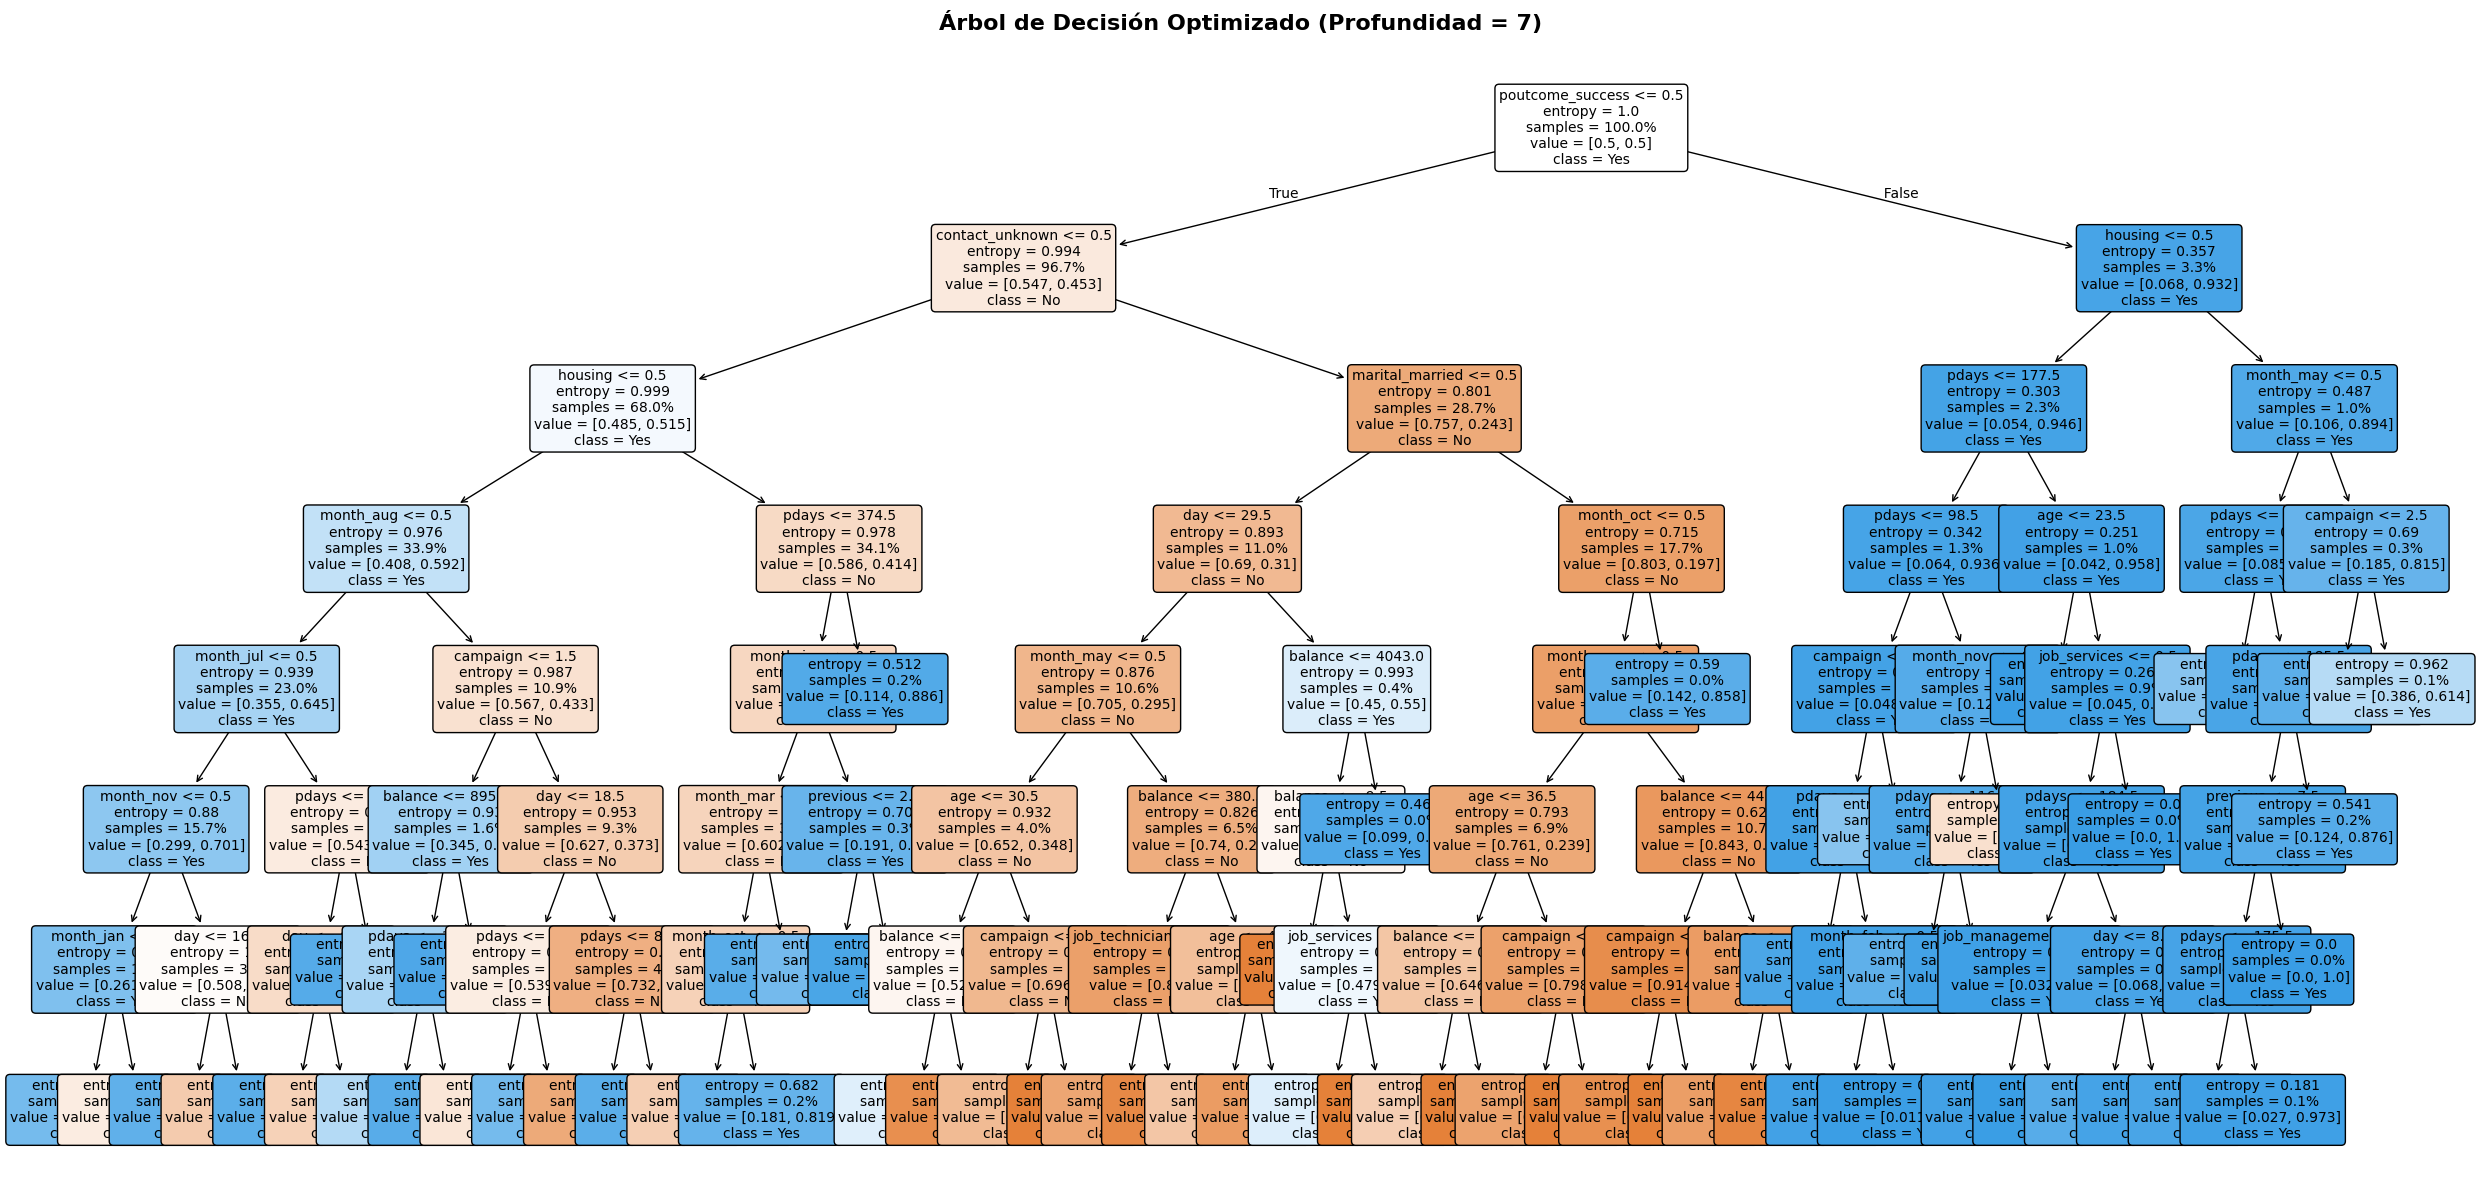


 El árbol muestra:
  • Naranja: Nodos que predicen 'No'
  • Verde/Azul: Nodos que predicen 'Yes'
  • Intensidad del color: Pureza del nodo


In [75]:

print("PASO 9: EVALUACIÓN FINAL DEL MODELO GANADOR")


print("\n MODELO SELECCIONADO: Árbol de Decisión Optimizado")
print(f"   Hiperparámetros: {grid_search.best_params_}")

# ========== VISUALIZACIÓN DEL ÁRBOL ==========

print("VISUALIZACIÓN DEL ÁRBOL")


plt.figure(figsize=(25, 12))
plot_tree(
    best_model,
    feature_names=X_train_tree.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    fontsize=10,
    proportion=True
)
plt.title('Árbol de Decisión Optimizado (Profundidad = 7)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n El árbol muestra:")
print("  • Naranja: Nodos que predicen 'No'")
print("  • Verde/Azul: Nodos que predicen 'Yes'")
print("  • Intensidad del color: Pureza del nodo")

IMPORTANCIA DE FEATURES

 TOP 15 FEATURES MÁS IMPORTANTES:
         Feature  Importance
poutcome_success    0.346776
 contact_unknown    0.178172
         housing    0.080942
           pdays    0.053606
             day    0.050739
       month_aug    0.049210
       month_jul    0.047588
       month_nov    0.030318
        campaign    0.028271
       month_jan    0.024609
       month_oct    0.021724
         balance    0.020229
       month_mar    0.015836
       month_jun    0.015363
 marital_married    0.012323


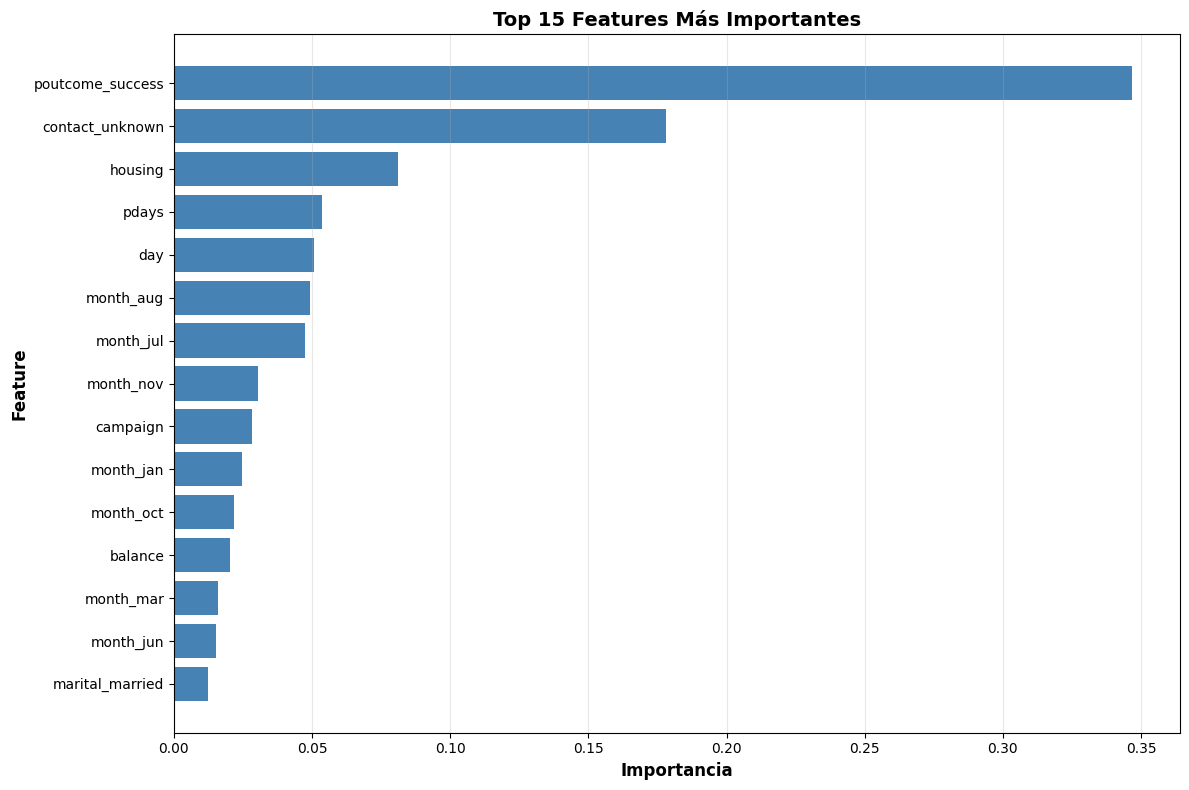


💡 INSIGHTS:
  • Top 5 features explican: 71.02% de las decisiones
  • Top 10 features explican: 89.02% de las decisiones


In [78]:
print("IMPORTANCIA DE FEATURES")


# Obtener importancia de features
importances = best_model.feature_importances_
feature_names = X_train_tree.columns

# Crear DataFrame ordenado
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n TOP 15 FEATURES MÁS IMPORTANTES:")

print(feature_importance_df.head(15).to_string(index=False))

# Visualización
plt.figure(figsize=(12, 8))
top_15 = feature_importance_df.head(15)
plt.barh(top_15['Feature'], top_15['Importance'], color='steelblue')
plt.xlabel('Importancia', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Features Más Importantes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Porcentaje acumulado
print("\n💡 INSIGHTS:")
top_5_sum = feature_importance_df.head(5)['Importance'].sum()
top_10_sum = feature_importance_df.head(10)['Importance'].sum()
print(f"  • Top 5 features explican: {top_5_sum*100:.2f}% de las decisiones")
print(f"  • Top 10 features explican: {top_10_sum*100:.2f}% de las decisiones")

CURVA ROC COMPARATIVA


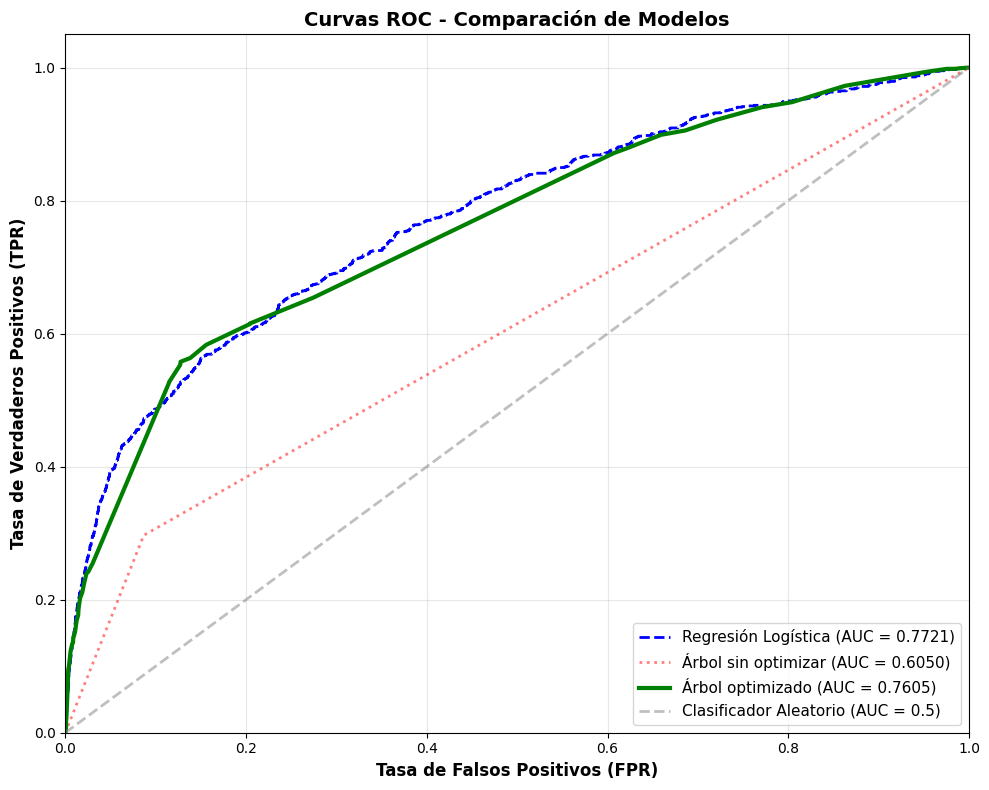


 AUC-ROC Scores:
  • Regresión Logística: 0.7721
  • Árbol sin optimizar:  0.6050
  • Árbol optimizado:     0.7605


In [79]:
from sklearn.metrics import roc_curve, auc


print("CURVA ROC COMPARATIVA")


# Calcular curvas ROC para los 3 modelos
fpr_lr, tpr_lr, _ = roc_curve(y_test_encoded, y_test_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test_encoded, y_test_proba_dt)
fpr_opt, tpr_opt, _ = roc_curve(y_test_encoded, y_test_proba_opt)

auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_opt = auc(fpr_opt, tpr_opt)

# Graficar
plt.figure(figsize=(10, 8))

plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label=f'Regresión Logística (AUC = {auc_lr:.4f})', linestyle='--')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, alpha=0.5,
         label=f'Árbol sin optimizar (AUC = {auc_dt:.4f})', linestyle=':')
plt.plot(fpr_opt, tpr_opt, color='green', lw=3,
         label=f'Árbol optimizado (AUC = {auc_opt:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5,
         label='Clasificador Aleatorio (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12, fontweight='bold')
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n AUC-ROC Scores:")
print(f"  • Regresión Logística: {auc_lr:.4f}")
print(f"  • Árbol sin optimizar:  {auc_dt:.4f}")
print(f"  • Árbol optimizado:     {auc_opt:.4f}")

ANÁLISIS DETALLADO DE LA MATRIZ DE CONFUSIÓN


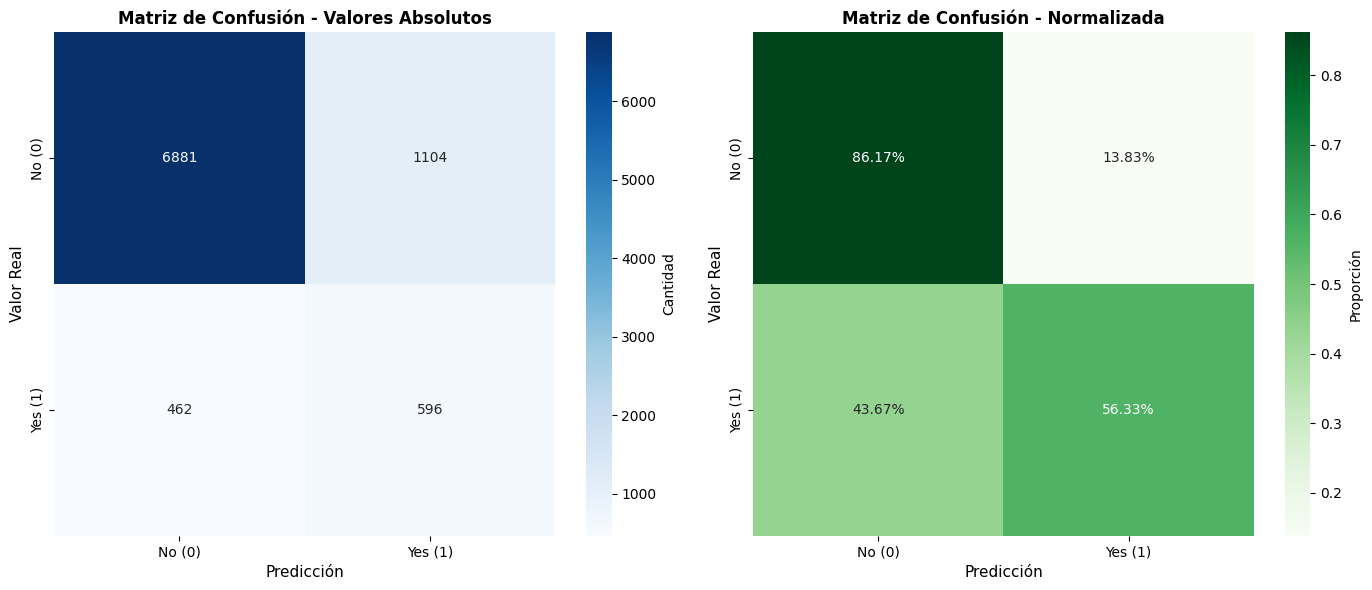


 DESGLOSE DE PREDICCIONES (sobre 9043 casos):
Verdaderos Negativos (TN): 6,881 (76.09%)
  → Predijo 'No' y era 'No' 

Falsos Positivos (FP):     1,104 (12.21%)
  → Predijo 'Yes' pero era 'No'  (Costo: contacto innecesario)

Falsos Negativos (FN):     462 (5.11%)
  → Predijo 'No' pero era 'Yes'  (Costo: cliente perdido)

Verdaderos Positivos (TP): 596 (6.59%)
  → Predijo 'Yes' y era 'Yes' 

 MÉTRICAS ADICIONALES:
  • Specificity (Tasa de Verdaderos Negativos): 0.8617
  • Negative Predictive Value: 0.9371


In [82]:
print("ANÁLISIS DETALLADO DE LA MATRIZ DE CONFUSIÓN")


# Matriz de confusión
cm = confusion_matrix(y_test_encoded, y_test_pred_opt)

# Visualización mejorada
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz en valores absolutos
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No (0)', 'Yes (1)'],
            yticklabels=['No (0)', 'Yes (1)'],
            ax=axes[0], cbar_kws={'label': 'Cantidad'})
axes[0].set_title('Matriz de Confusión - Valores Absolutos', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontsize=11)
axes[0].set_xlabel('Predicción', fontsize=11)

# Matriz normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['No (0)', 'Yes (1)'],
            yticklabels=['No (0)', 'Yes (1)'],
            ax=axes[1], cbar_kws={'label': 'Proporción'})
axes[1].set_title('Matriz de Confusión - Normalizada', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontsize=11)
axes[1].set_xlabel('Predicción', fontsize=11)

plt.tight_layout()
plt.show()

# Análisis detallado
TN, FP, FN, TP = cm.ravel()

print(f"\n DESGLOSE DE PREDICCIONES (sobre {len(y_test_encoded)} casos):")

print(f"Verdaderos Negativos (TN): {TN:,} ({TN/len(y_test_encoded)*100:.2f}%)")
print(f"  → Predijo 'No' y era 'No' ")
print(f"\nFalsos Positivos (FP):     {FP:,} ({FP/len(y_test_encoded)*100:.2f}%)")
print(f"  → Predijo 'Yes' pero era 'No'  (Costo: contacto innecesario)")
print(f"\nFalsos Negativos (FN):     {FN:} ({FN/len(y_test_encoded)*100:.2f}%)")
print(f"  → Predijo 'No' pero era 'Yes'  (Costo: cliente perdido)")
print(f"\nVerdaderos Positivos (TP): {TP:,} ({TP/len(y_test_encoded)*100:.2f}%)")
print(f"  → Predijo 'Yes' y era 'Yes' ")

# Métricas derivadas
specificity = TN / (TN + FP)
npv = TN / (TN + FN) if (TN + FN) > 0 else 0

print(f"\n MÉTRICAS ADICIONALES:")
print(f"  • Specificity (Tasa de Verdaderos Negativos): {specificity:.4f}")
print(f"  • Negative Predictive Value: {npv:.4f}")

In [81]:
print("ANÁLISIS DE ERRORES")


# Crear DataFrame con predicciones
errores_df = pd.DataFrame({
    'Real': y_test_encoded.values,
    'Predicción': y_test_pred_opt,
    'Probabilidad': y_test_proba_opt,
    'Correcto': y_test_encoded.values == y_test_pred_opt
})

# Añadir features originales (sin escalar para mejor interpretación)
errores_df = pd.concat([
    errores_df.reset_index(drop=True),
    X_test_selected.reset_index(drop=True)
], axis=1)

# Casos mal clasificados
incorrectos = errores_df[~errores_df['Correcto']]

print(f"\n RESUMEN DE ERRORES:")
print(f"  Total de errores: {len(incorrectos)} de {len(errores_df)} ({len(incorrectos)/len(errores_df)*100:.2f}%)")

# Falsos Positivos
fp_casos = incorrectos[(incorrectos['Real'] == 0) & (incorrectos['Predicción'] == 1)]
print(f"\n FALSOS POSITIVOS: {len(fp_casos)}")
print("  (Predijo 'Yes' pero era 'No')")
if len(fp_casos) > 0:
    print("\n  Características promedio de FP:")
    print(f"    Probabilidad media: {fp_casos['Probabilidad'].mean():.4f}")
    print(f"    Edad media: {fp_casos['age'].mean():.1f} años")
    print(f"    Balance medio: {fp_casos['balance'].mean():.2f}€")
    print(f"\n  Top 3 trabajos en FP:")
    print(fp_casos['job'].value_counts().head(3))

# Falsos Negativos
fn_casos = incorrectos[(incorrectos['Real'] == 1) & (incorrectos['Predicción'] == 0)]
print(f"\n FALSOS NEGATIVOS: {len(fn_casos)}")
print("  (Predijo 'No' pero era 'Yes')")
if len(fn_casos) > 0:
    print("\n  Características promedio de FN:")
    print(f"    Probabilidad media: {fn_casos['Probabilidad'].mean():.4f}")
    print(f"    Edad media: {fn_casos['age'].mean():.1f} años")
    print(f"    Balance medio: {fn_casos['balance'].mean():.2f}€")
    print(f"\n  Top 3 trabajos en FN:")
    print(fn_casos['job'].value_counts().head(3))

# Casos más difíciles (probabilidades cerca del umbral 0.5)
print(f"\n CASOS 'DIFÍCILES' (Probabilidad entre 0.45-0.55):")
casos_dificiles = errores_df[
    (errores_df['Probabilidad'] >= 0.45) & 
    (errores_df['Probabilidad'] <= 0.55)
]
print(f"  Total: {len(casos_dificiles)} casos ({len(casos_dificiles)/len(errores_df)*100:.2f}%)")
print(f"  Aciertos en casos difíciles: {casos_dificiles['Correcto'].sum()} ({casos_dificiles['Correcto'].mean()*100:.2f}%)")

ANÁLISIS DE ERRORES

 RESUMEN DE ERRORES:
  Total de errores: 1566 de 9043 (17.32%)

 FALSOS POSITIVOS: 1104
  (Predijo 'Yes' pero era 'No')

  Características promedio de FP:
    Probabilidad media: 0.7585
    Edad media: 41.3 años
    Balance medio: 1784.63€

  Top 3 trabajos en FP:
job
management    239
technician    191
admin.        145
Name: count, dtype: int64

 FALSOS NEGATIVOS: 462
  (Predijo 'No' pero era 'Yes')

  Características promedio de FN:
    Probabilidad media: 0.3558
    Edad media: 40.3 años
    Balance medio: 1466.24€

  Top 3 trabajos en FN:
job
management     113
blue-collar     85
technician      66
Name: count, dtype: int64

 CASOS 'DIFÍCILES' (Probabilidad entre 0.45-0.55):
  Total: 253 casos (2.80%)
  Aciertos en casos difíciles: 147 (58.10%)
